# Final Training
The final version of the training, minus the timing varaiables.

Set the name of this training, and the job number it is based on. This will keep the resulting output xml files seperate below.

In [39]:
jobId = 133
training_name = "full_event_prev_final_timeing_grad1000"

## Initalization

In [40]:
from bdt_training_scikit_tools import load_trimmed_sample, default_training_variable_list, \
    test_train_samples, prep_samples, default_training, calc_performance, get_fraction_of_events
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools

In [41]:
training_file_stub = 'training_{0}_{1}'.format(jobId, training_name)

## Load data

In [42]:
%%time
input_events = load_trimmed_sample(jobId)

Job 133:
  BIB: 800000 events
  Multijet: 800000 events
  Signal: 800000 events
  [800000, 800000, 473600]
CPU times: user 41.4 s, sys: 6.69 s, total: 48.1 s
Wall time: 32.2 s


In [43]:
events_25 = get_fraction_of_events(input_events, 0.25)
print ([len(i.index) for i in events_25])

[200387, 199675, 118454]


In [44]:
events_to_use = input_events

## Training
Default training variables. Likely were arrived at by analysis in the Training Variables workbook.

In [45]:
training_variables = ['EnergyDensity',
 'BIBDeltaTimingM',
 'JetPt',
 'HadronicLayer1Fraction',
 'ShowerCenter',
 'JetLat',
 'FirstClusterRadius',
 'JetLong',
 'MaxTrackPt',
 'PredictedLxy',
 'BIBDeltaTimingP',
 'PredictedLz',
 'SumPtOfAllTracks']

Run the training to get a bdt back.

In [46]:
%%time
# Split into testing and training samples
train, test = test_train_samples(events_to_use)

# Prep samples for training
all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2], training_variable_list=training_variables)

CPU times: user 5.01 s, sys: 1.14 s, total: 6.15 s
Wall time: 3.1 s


In [47]:
%%time
bdt = default_training(all_events, training_weight, all_events_class)

CPU times: user 4h 23min 41s, sys: 58.9 s, total: 4h 24min 40s
Wall time: 3h 30min 53s


Calculate the performance for this training

In [48]:
%%time
calc_performance(bdt, input_events, training_variables=training_variables)

CPU times: user 56.1 s, sys: 1.73 s, total: 57.8 s
Wall time: 52.4 s


{'BIBinBIB': 773156.0,
 'MJinBIB': 15898371.660312472,
 'HSSinBIB': 15430.0,
 'BIBinMJ': 2269.0,
 'MJinMJ': 729652474.900382,
 'HSSinMJ': 4543.0,
 'BIBinHSS': 24575.0,
 'MJinHSS': 5514622.748610274,
 'HSSinHSS': 453627.0,
 'BIBEff': 0.966445,
 'MJEff': 0.9714898430510795,
 'HSSEff': 0.9578272804054054,
 'BIBBack': 15913801.660312472,
 'MJBack': 6812.0,
 'HSSBack': 5539197.748610274,
 'BIBSsqrtB': 193.8117754648011,
 'MJSsqrtB': 8840538.91580271,
 'HSSSsqrtB': 192.7416005681729,
 'BIBTotalWeight': 800000.0,
 'MJTotalWeight': 751065469.309305,
 'HSSTotalWeight': 473600.0,
 'BIBTotalCount': 800000,
 'MJTotalCount': 800000,
 'HSSTotalCount': 473600}

In [49]:
from sklearn.externals import joblib
joblib.dump(bdt, training_file_stub + '.pkl') 

['training_133_full_event_prev_final_timeing_grad1000.pkl']

## Conversion to TMVA format

In [50]:
import mlglue
import mlglue.tree
from sklearn.externals import joblib
bdt1 = joblib.load(training_file_stub + '.pkl')
bdtGeneral = mlglue.tree.BDTsklearn(bdt1, list(all_events.columns), ['BIB', 'MJ', 'Signal'])
bdtGeneral.to_tmva(training_file_stub + ".xml")

norm is 1.0


## Performance
Look at some generic performance plots for the bdt.

In [51]:
perf_events, perf_events_class, perf_training_weight, perf_evaluation_weight = prep_samples(input_events[0], input_events[1], input_events[2], training_variable_list=training_variables)

In [52]:
predicted_class = bdt1.predict(perf_events)

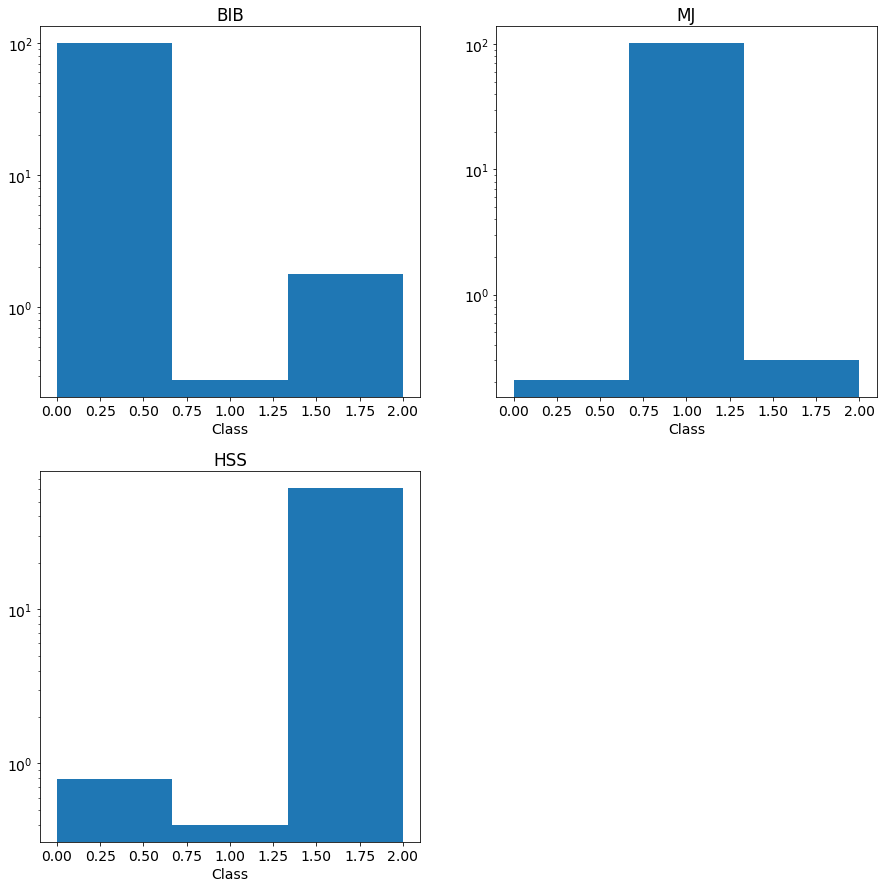

In [53]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot(221)
ax.hist(predicted_class[perf_events_class.Class == 0], weights=perf_training_weight[perf_events_class.Class == 0], bins=3)
ax.set_xlabel('Class')
ax.set_title('BIB')
ax.set_yscale('log')

ax = plt.subplot(222)
ax.hist(predicted_class[perf_events_class.Class == 1], weights=perf_training_weight[perf_events_class.Class == 1], bins=3)
ax.set_xlabel('Class')
ax.set_title('MJ')
ax.set_yscale('log')

ax = plt.subplot(223)
ax.hist(predicted_class[perf_events_class.Class == 2], weights=perf_training_weight[perf_events_class.Class == 2], bins=3)
ax.set_xlabel('Class')
ax.set_title('HSS')
ax.set_yscale('log')

In [54]:
predicted_prob = bdt1.predict_proba(perf_events)

In [55]:
def make_weights (cls):
    w = np.array([perf_training_weight[perf_events_class.Class == cls],
        perf_training_weight[perf_events_class.Class == cls],
        perf_training_weight[perf_events_class.Class == cls]])
    return w.T

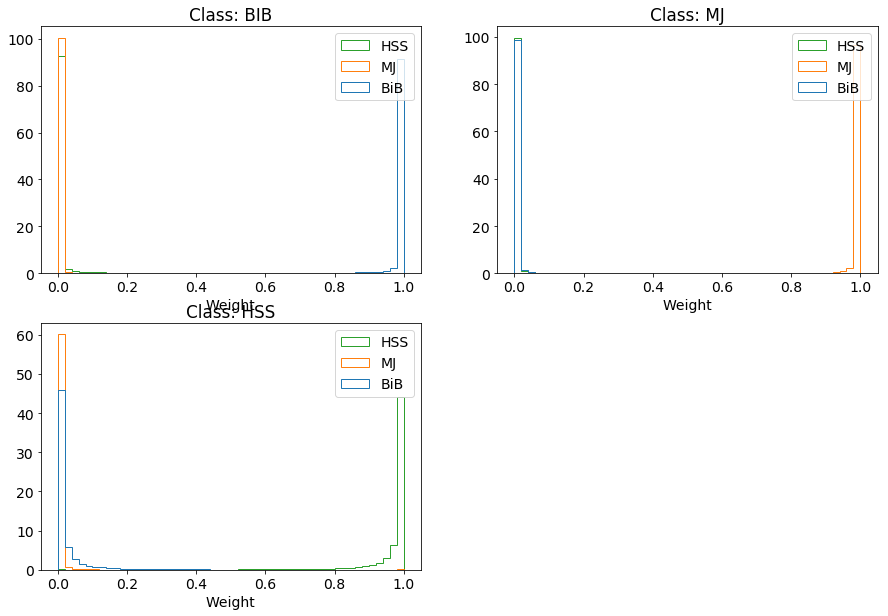

In [56]:
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(221)
ax.hist(predicted_prob[perf_events_class.Class == 0], weights=make_weights(0), label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: BIB')
ax.legend()

ax = plt.subplot(222)
ax.hist(predicted_prob[perf_events_class.Class == 1], weights=make_weights(1), label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: MJ')
ax.legend()

ax = plt.subplot(223)
ax.hist(predicted_prob[perf_events_class.Class == 2], weights=make_weights(2), label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: HSS')
ax.legend()

## TMVA Cross Check
We always have trouble with that. We need to look to see what we can expect with TMVA. Below there is Bib, MJ, and Signal, all three classes. 5 events are taken (first jet pt eta phi are shown along with event number so they can be correlated with the real full root trees). The full inputs are shown, in the proper order to be fed to the bdt. Then the result of the TMVA translation is evaluated, and then the probabilities from the sklean classifier are shown. A direct match isn't expected, but the trents (e.g. signal has the class2 column always larger than the bib or mj columns).

### What is wrong with this translation?
I'm using a slightly modified version of mlglue to do the translation. Yet, as you can see below, the MJ, Sig, and background come out almost alike. And the classifier works rather well when it is run internally. So... what is going on?

### BiB (class 0)
First lets look at BiB. We'll get some absolute numbers out of the weight calculations

In [57]:
events_to_use[0][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
0,303846,1290270786,101.7680,0.671180,0.668020
1,303846,1289734246,143.2400,1.302650,-0.141964
2,303846,1291357297,109.4470,0.757105,3.096500
3,303846,1294629602,135.7760,0.011375,-1.721400
4,303846,1288767250,59.3792,0.628752,-0.494102


In [58]:
subsample = all_events[all_events_class.Class==0][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
0,0.002670,26.887600,143.2400,0.968134,1864.0,0.159180,4800,0.271484,0.538194,2102.600,-0.646996,4188.720,0.538194
1,0.000935,17.486100,109.4470,-0.001545,2864.0,0.373047,3904,0.292969,0.000000,2912.970,0.914904,2571.480,0.000000
2,0.002579,0.029894,135.7760,0.990177,964.0,0.423828,2448,0.291016,0.000000,2111.500,0.458046,438.670,0.000000
3,0.000139,-22.359300,59.3792,0.563293,1024.0,0.953125,2768,0.738281,0.818729,824.584,-30.330000,686.581,0.818729
4,0.000809,2.662320,133.3790,0.014341,1688.0,0.281250,3056,0.078125,0.000000,2579.500,-0.719869,655.392,0.000000


In [59]:
bdtGeneral.eval(subsample)

array([[0.35952712, 0.3181333 , 0.32233959],
       [0.35365084, 0.31985102, 0.32649814],
       [0.36226331, 0.32243323, 0.31530346],
       [0.35517507, 0.33159679, 0.31322814],
       [0.36253888, 0.32296546, 0.31449566]])

In [60]:
bdt1.predict_proba(subsample)

array([[9.99979475e-01, 4.88417125e-06, 1.56407397e-05],
       [9.99663762e-01, 4.34720737e-05, 2.92766196e-04],
       [9.99990432e-01, 8.76177589e-06, 8.06308504e-07],
       [9.98956160e-01, 1.04083819e-03, 3.00222409e-06],
       [9.99989846e-01, 9.57629455e-06, 5.78187830e-07]])

### MultiJet (class 1)

Ok, now lets look at MJ, which is class 1. Note that the run number is not pulled correctly here. :(

In [61]:
events_to_use[1][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
0,284500,1652343,243.0610,-0.890647,2.14866
1,284500,1652343,98.8450,-0.419785,1.96751
2,284500,1652343,93.1911,-0.242547,2.80465
3,284500,1652221,121.9710,-0.935860,2.44594
4,284500,1652221,102.9700,-0.691468,1.25401


In [62]:
subsample = all_events[all_events_class.Class==1][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
532863,0.004791,2.61928,121.9710,0.901575,366.0,0.902344,2512,0.968750,16.8386,737.983,14.73670,810.791,29.6025
532864,0.003418,2.18392,102.9700,0.693256,244.0,0.847656,2352,0.691406,16.4385,744.055,12.99140,487.665,45.4132
532865,0.000725,31.37850,424.5490,0.505638,2272.0,0.972656,5056,0.734375,110.9180,587.731,2.54659,886.868,211.9560
532866,0.005554,14.10390,73.6816,0.672046,197.0,0.871094,2464,0.832031,16.8371,860.230,1.84075,1009.950,38.7491
532867,0.004181,7.23076,67.8031,1.000000,163.0,0.972656,1704,0.941406,54.0849,889.963,4.37807,-128.344,299.8710


In [63]:
bdtGeneral.eval(subsample)

array([[0.32327419, 0.34872271, 0.32800311],
       [0.32313453, 0.35107687, 0.3257886 ],
       [0.31750565, 0.35536056, 0.32713379],
       [0.33016535, 0.3445149 , 0.32531975],
       [0.32077259, 0.35786571, 0.3213617 ]])

In [64]:
bdt1.predict_proba(subsample)

array([[5.09319014e-04, 9.97612450e-01, 1.87823049e-03],
       [2.49311386e-04, 9.99263092e-01, 4.87596479e-04],
       [1.27959045e-05, 9.99768160e-01, 2.19044112e-04],
       [1.39313996e-02, 9.83327309e-01, 2.74129191e-03],
       [1.76460830e-05, 9.99964056e-01, 1.82979296e-05]])

### Signal (class 2)

Finally, lets look at signal

In [65]:
events_to_use[2][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
0,284500,171076,158.9240,-0.985681,0.255070
1,284500,171242,117.5200,-0.328739,3.004210
2,284500,171705,200.1870,1.260690,-0.629426
3,284500,171165,80.9756,1.358970,0.033844
6,284500,171034,248.2560,0.501694,-0.495947


In [66]:
subsample = all_events[all_events_class.Class==2][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
1066442,0.000671,4.37826,158.924,0.000286,2992.0,0.910156,5312,0.617188,0.000000,3185.480,31.25680,3068.820,0.000000
1066443,0.000385,13.06520,117.520,0.223429,1464.0,0.640625,3056,0.785156,0.000000,2509.270,19.67940,826.910,0.000000
1066444,0.028931,9.72733,248.256,0.493671,218.0,0.832031,1928,0.679688,0.432695,886.061,3.61386,313.347,0.432695
1066445,0.017700,2.52680,105.639,0.408885,314.0,0.863281,3184,0.941406,0.706930,796.294,20.72640,1204.780,0.706930
1066446,0.000610,13.39250,159.514,0.009390,1552.0,0.632812,3056,0.640625,1.214390,2622.160,10.79180,569.214,1.214390


In [67]:
bdtGeneral.eval(subsample)

array([[0.32744427, 0.32211439, 0.35044134],
       [0.33739162, 0.3186497 , 0.34395869],
       [0.3239724 , 0.33087848, 0.34514911],
       [0.32599329, 0.33290358, 0.34110313],
       [0.3374154 , 0.31937639, 0.34320821]])

In [68]:
bdt1.predict_proba(subsample)

array([[1.30455436e-03, 2.53389479e-04, 9.98442056e-01],
       [1.44171386e-01, 4.76270688e-04, 8.55352343e-01],
       [2.02230805e-03, 1.67090056e-02, 9.81268686e-01],
       [1.11992278e-02, 9.14579564e-02, 8.97342816e-01],
       [1.74235317e-01, 7.17760413e-04, 8.25046922e-01]])

## Plots of TMVA Translation Performance

In [69]:
%%time
predicted_tmva_weights = bdtGeneral.eval(perf_events)

CPU times: user 21min 41s, sys: 5min 38s, total: 27min 20s
Wall time: 6min 50s


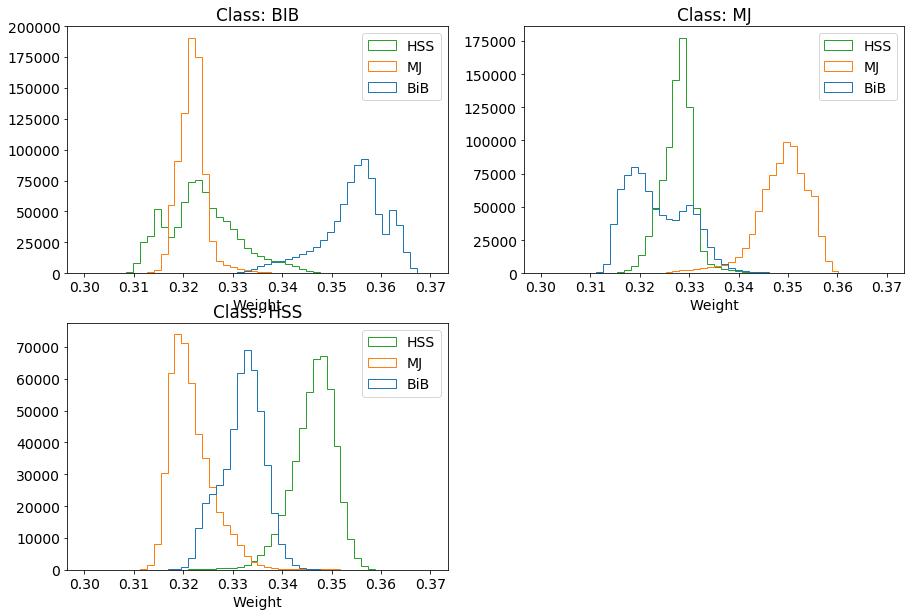

In [70]:
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(221)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 0], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step', range=[0.3, 0.37])
ax.set_xlabel('Weight')
ax.set_title('Class: BIB')
ax.legend()

ax = plt.subplot(222)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 1], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step', range=[0.3, 0.37])
ax.set_xlabel('Weight')
ax.set_title('Class: MJ')
ax.legend()

ax = plt.subplot(223)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 2], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step', range=[0.3, 0.37])
ax.set_xlabel('Weight')
ax.set_title('Class: HSS')
ax.legend()

Note in this version how everything is on top of itself. :(